In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from itertools import product
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D
import utils

In [2]:
sq = math.sqrt(1/2)
R = np.array([[sq, -sq, 0],
              [sq, sq, 0],
              [0, 0, 1]])
t = np.array([[0, 0, 10]])

K = np.array([[1000, 0, 960],
              [0, 1000, 540],
              [0, 0, 1]])

In [3]:
P = utils.getP(K, R, t)
print(P)

[[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]


In [4]:
Q = list(product([0, 1], repeat=3))

Q = np.array(Q).T

q = P @ utils.PiInv(Q)

print(utils.Pi(q))

[[ 960.          960.          889.28932188  895.71756535 1030.71067812
  1024.28243465  960.          960.        ]
 [ 540.          540.          610.71067812  604.28243465  610.71067812
   604.28243465  681.42135624  668.56486931]]


In [5]:
P_ = utils.pest(Q, q)
print(P_)

q_ = P_ @ utils.PiInv(Q)

RMSE = np.sqrt(np.mean((utils.Pi(q)-utils.Pi(q_))**2))
print(RMSE)

[[-6.33639514e-02  6.33639514e-02 -8.60257530e-02 -8.60257530e-01]
 [-6.33639514e-02 -6.33639514e-02 -4.83894861e-02 -4.83894861e-01]
 [ 1.14654380e-17 -1.22894316e-16 -8.96101594e-05 -8.96101594e-04]]
1.3624059885412874e-10


4.3

In [6]:
def checkerboard_points(n, m):
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append(np.array([[i-(n-1)/2, j-(m-1)/2, 0]]))
    return np.vstack(Q).T

In [7]:
def rot(phix, phiy, phiz):
    return Rotation.from_euler('xyz', [phix, phiy, phiz]).as_matrix()

In [8]:
Qom = checkerboard_points(10, 20)
Qa = rot(math.pi/10, 0, 0) @ Qom
Qb = rot(0, 0, 0) @ Qom
Qc = rot(-math.pi/10, 0, 0) @ Qom


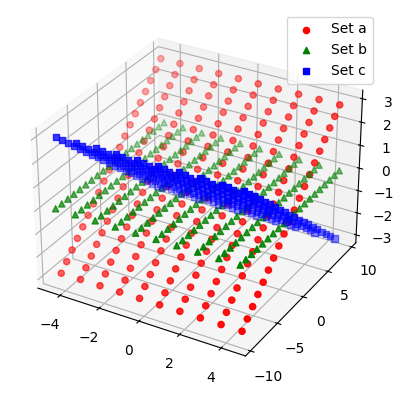

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Qa[0], Qa[1], Qa[2], c='r', marker='o', label='Set a')
ax.scatter(Qb[0], Qb[1], Qb[2], c='g', marker='^', label='Set b')
ax.scatter(Qc[0], Qc[1], Qc[2], c='b', marker='s', label='Set c')

ax.legend()

plt.show()

In [10]:
qa = P @ utils.PiInv(Qa)
qb = P @ utils.PiInv(Qb)
qc = P @ utils.PiInv(Qc)

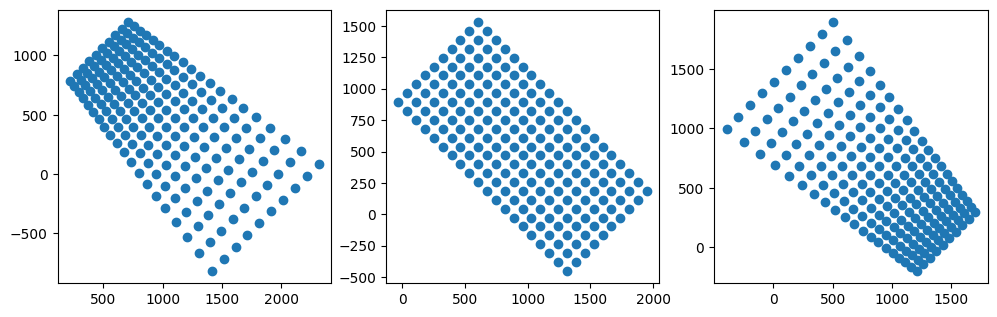

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(utils.Pi(qa)[0], utils.Pi(qa)[1])
axs[1].scatter(utils.Pi(qb)[0], utils.Pi(qb)[1])
axs[2].scatter(utils.Pi(qc)[0], utils.Pi(qc)[1])

for ax in axs:
    ax.set_aspect('equal')

plt.show()

In [12]:
def estimateHomographies(Qom, qs):
    qom = Qom[:-1,:] # remove z coord from 3D point
    Hs = []
    for q in qs:
        Hs.append(utils.hest(q, qom))
    return Hs

In [13]:
Hs = estimateHomographies(Qom, [qa, qb, qc])
qom = utils.PiInv(Qom[:-1,:])

qa_ = utils.Pi(Hs[0] @ qom)
qb_ = utils.Pi(Hs[1] @ qom)
qc_ = utils.Pi(Hs[2] @ qom)

print((qa_ - utils.Pi(qa)).sum())
print((qb_ - utils.Pi(qb)).sum())
print((qc_ - utils.Pi(qc)).sum())

3.926171388002331e-09
4.833930233871797e-08
-5.492801458117924e-08


4.6

In [14]:
def getv(H, a, b):
    return np.array([
        H[0][a] * H[0][b],
        H[0][a] * H[1][b] + H[1][a] * H[0][b],
        H[1][a] * H[1][b],
        H[2][a] * H[0][b] + H[0][a] * H[2][b],
        H[2][a] * H[1][b] + H[1][a] * H[2][b],
        H[2][a] * H[2][b]
    ])

def estimate_b(Hs):
    V = []
    for H in Hs:
        V.append(getv(H, 0, 1))
        V.append(getv(H, 0, 0) - getv(H, 1, 1))
    V = np.stack(V)
    U, S, VT = np.linalg.svd(V)
    return VT[-1]

def estimateIntrinsics(Hs):
    b = estimate_b(Hs)
    v0 = (b[1]*b[3]-b[0]*b[4])/(b[0]*b[2]-b[1]*b[1])
    l = b[5]-(b[3]*b[3]+v0*(b[1]*b[3]-b[0]*b[4]))/b[0]
    a = math.sqrt(l/b[0])
    be = math.sqrt(l*b[0]/(b[0]*b[2]-b[1]*b[1]))
    g = -b[1]*a*a*be/l
    u0 = g*v0/be-b[3]*a*a/l
    return np.array([[a, g, u0],
                     [0, be, v0],
                     [0, 0, 1]])

In [15]:
K_ = estimateIntrinsics(Hs)
print(K)
print(K_)


[[1000    0  960]
 [   0 1000  540]
 [   0    0    1]]
[[1.00000000e+03 2.26340983e-09 9.60000000e+02]
 [0.00000000e+00 1.00000000e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


4.8

In [16]:
def estimateExtrinsics(K, Hs):
    Kinv = np.linalg.inv(K)
    Rs = []
    ts = []
    for H in Hs:
        h1 = np.expand_dims(H[:,0], axis=0).T
        h2 = np.expand_dims(H[:,1], axis=0).T
        h3 = np.expand_dims(H[:,2], axis=0).T
        l = 1/np.linalg.norm(Kinv @ h1)
        r1 = l * Kinv @ h1
        r2 = l * Kinv @ h2
        r3 = np.expand_dims(np.cross(r1.flatten(), r2.flatten()), axis=0).T
        ts.append(l * Kinv @ h3)
        Rs.append(np.concatenate((r1, r2, r3), axis=1))
    return Rs, ts


In [17]:
Rs, ts = estimateExtrinsics(K_, Hs)
print(Rs[0] / Rs[0][0, 0])
print(Rs[1] / Rs[1][0, 0])
print(Rs[2] / Rs[2][0, 0])
print(ts)

[[ 1.00000000e+00 -9.51056516e-01 -3.09016994e-01]
 [ 1.00000000e+00  9.51056516e-01  3.09016994e-01]
 [ 1.78715901e-12  4.37016024e-01 -1.34499702e+00]]
[[ 1.00000000e+00 -1.00000000e+00  1.92751677e-12]
 [ 1.00000000e+00  1.00000000e+00  2.24675815e-12]
 [-2.95165811e-12 -2.25737746e-13  1.41421356e+00]]
[[ 1.00000000e+00 -9.51056516e-01 -3.09016994e-01]
 [ 1.00000000e+00  9.51056516e-01  3.09016994e-01]
 [ 2.36608883e-12 -4.37016024e-01  1.34499702e+00]]
[array([[ 5.47241187e-14],
       [ 1.84882024e-12],
       [-1.00000000e+01]]), array([[-3.4772721e-13],
       [-2.0077164e-12],
       [ 1.0000000e+01]]), array([[-5.04877811e-13],
       [-2.09785436e-12],
       [ 1.00000000e+01]])]


In [18]:
def calibratecamera(qs, Q):
    Hs = estimateHomographies(Q, qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K, Hs)
    return K, Rs, ts

In [19]:
K, Rs, ts = calibratecamera([qa, qb, qc], Qom)
qa_est = utils.getP(K, Rs[0], ts[0].T)@utils.PiInv(Qom)
qb_est = utils.getP(K, Rs[1], ts[1].T)@utils.PiInv(Qom)
qc_est = utils.getP(K, Rs[2], ts[2].T)@utils.PiInv(Qom)
# RMSE:
print(np.sqrt(np.mean((utils.Pi(qa_est) - utils.Pi(qa))**2)))
print(np.sqrt(np.mean((utils.Pi(qb_est) - utils.Pi(qb))**2)))
print(np.sqrt(np.mean((utils.Pi(qc_est) - utils.Pi(qc))**2)))

6.70778973018577e-10
5.586874055003425e-10
5.066578649943315e-10


In [21]:
for i in range(3):
    print(ts[i])

[[ 5.47241187e-14]
 [ 1.84882024e-12]
 [-1.00000000e+01]]
[[-3.4772721e-13]
 [-2.0077164e-12]
 [ 1.0000000e+01]]
[[-5.04877811e-13]
 [-2.09785436e-12]
 [ 1.00000000e+01]]


The actual positions of the cameras: (containing sign error)

In [22]:
for i in range(3):
    print(-Rs[i].T@ts[i])

[[-1.12911134e-11]
 [-3.09016994e+00]
 [ 9.51056516e+00]]
[[ 2.25369248e-11]
 [ 2.76999653e-12]
 [-1.00000000e+01]]
[[-1.48903650e-11]
 [ 3.09016994e+00]
 [-9.51056516e+00]]


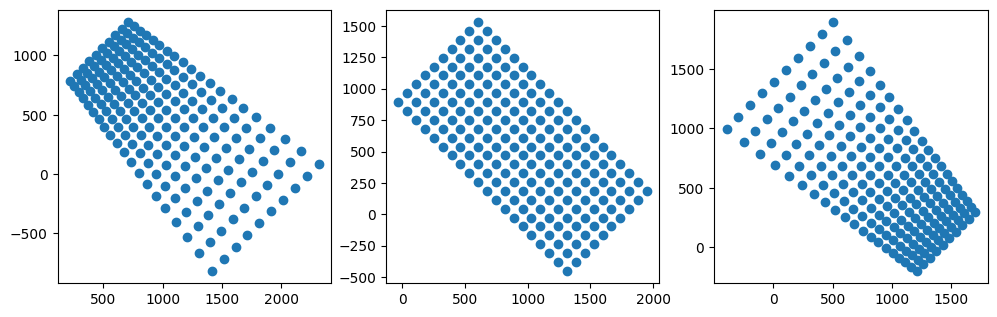

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(utils.Pi(qa_est)[0], utils.Pi(qa_est)[1])
axs[1].scatter(utils.Pi(qb_est)[0], utils.Pi(qb_est)[1])
axs[2].scatter(utils.Pi(qc_est)[0], utils.Pi(qc_est)[1])

for ax in axs:
    ax.set_aspect('equal')

plt.show()